# SatCLIP Resolution Tests: Multi-Scale Evaluation

Comprehensive testing of L=10 vs L=40 across multiple spatial scales and boundary types.

## Test Categories

### Paper Benchmarks (Replication)
1. **Air Temperature** - Regression, global, smooth spatial variation
2. **Elevation** - Regression, global, varies at all scales
3. **Population Density** - Regression, global, clustered around cities
4. **Countries** - Classification, ~200 classes, sharp political boundaries
5. **Biomes** - Classification, 14 classes, fuzzy ecological boundaries
6. **Ecoregions** - Classification, 846 classes, fine-grained

### Multi-Scale Boundary Tests
7. **States/Provinces** - ~4000 classes, medium-scale boundaries
8. **Checkerboard at Multiple Scales** - Controlled synthetic test

For GPU acceleration: `Runtime -> Change runtime type -> T4 GPU`

---
## 1. Setup

In [1]:
# Clone SatCLIP repository (only needed in Colab)
import os
if 'COLAB_GPU' in os.environ:
    !rm -rf sample_data .config satclip 2>/dev/null
    !git clone https://github.com/1hamzaiqbal/satclip.git

Cloning into 'satclip'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 331 (delta 114), reused 107 (delta 97), pack-reused 187 (from 2)
Receiving objects: 100% (331/331), 78.47 MiB | 43.32 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [2]:
# Install dependencies
!pip install lightning rasterio torchgeo huggingface_hub geopandas shapely --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.8/241.8 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import sys
import os
import zipfile
from urllib import request
import io

# Handle path for both Colab and local execution
if 'COLAB_GPU' in os.environ:
    sys.path.append('./satclip/satclip')
else:
    sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'satclip'))

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from huggingface_hub import hf_hub_download
from load import get_satclip
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Using device: cuda


In [4]:
# Load both models
print("Loading L=10 model...")
model_l10 = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ViT16-L10", "satclip-vit16-l10.ckpt"),
    device=device,
)
model_l10.eval()

print("Loading L=40 model...")
model_l40 = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ViT16-L40", "satclip-vit16-l40.ckpt"),
    device=device,
)
model_l40.eval()
print("Both models loaded!")

Loading L=10 model...


satclip-vit16-l10.ckpt:   0%|          | 0.00/103M [00:00<?, ?B/s]

using pretrained moco vit16
Downloading: "https://hf.co/torchgeo/vit_small_patch16_224_sentinel2_all_moco/resolve/1cb683f6c14739634cdfaaceb076529adf898c74/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth" to /root/.cache/torch/hub/checkpoints/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth


100%|██████████| 86.5M/86.5M [00:00<00:00, 336MB/s]


Loading L=40 model...


satclip-vit16-l40.ckpt:   0%|          | 0.00/121M [00:00<?, ?B/s]

using pretrained moco vit16
Both models loaded!


In [5]:
# ============================================
# HELPER FUNCTIONS (same setup as paper)
# ============================================

def get_embeddings(model, coords):
    """Get embeddings for coordinates."""
    coords_tensor = torch.tensor(coords).double()
    with torch.no_grad():
        emb = model(coords_tensor.to(device)).cpu().numpy()
    return emb

def evaluate_classification(emb_l10, emb_l40, y, task_name, use_mlp=True):
    """
    Evaluate classification task with both models.
    Uses MLP by default (same as paper).
    """
    # Split data
    X_train_l10, X_test_l10, y_train, y_test = train_test_split(
        emb_l10, y, test_size=0.3, random_state=42
    )
    X_train_l40, X_test_l40, _, _ = train_test_split(
        emb_l40, y, test_size=0.3, random_state=42
    )

    if use_mlp:
        # MLP classifier (paper uses similar architecture)
        clf_l10 = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500,
                                 random_state=42, early_stopping=True)
        clf_l40 = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500,
                                 random_state=42, early_stopping=True)
    else:
        clf_l10 = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
        clf_l40 = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

    clf_l10.fit(X_train_l10, y_train)
    clf_l40.fit(X_train_l40, y_train)

    acc_l10 = accuracy_score(y_test, clf_l10.predict(X_test_l10))
    acc_l40 = accuracy_score(y_test, clf_l40.predict(X_test_l40))

    return acc_l10, acc_l40

def evaluate_regression(emb_l10, emb_l40, y, task_name, use_mlp=True):
    """
    Evaluate regression task with both models.
    Uses MLP by default (same as paper).
    """
    # Split data (paper uses 50/50 split)
    X_train_l10, X_test_l10, y_train, y_test = train_test_split(
        emb_l10, y, test_size=0.5, random_state=42
    )
    X_train_l40, X_test_l40, _, _ = train_test_split(
        emb_l40, y, test_size=0.5, random_state=42
    )

    if use_mlp:
        # MLP regressor (paper uses 3 hidden layers of 64)
        reg_l10 = MLPRegressor(hidden_layer_sizes=(64, 64, 64), max_iter=3000,
                                random_state=42, early_stopping=True)
        reg_l40 = MLPRegressor(hidden_layer_sizes=(64, 64, 64), max_iter=3000,
                                random_state=42, early_stopping=True)
    else:
        reg_l10 = Ridge(alpha=1.0)
        reg_l40 = Ridge(alpha=1.0)

    reg_l10.fit(X_train_l10, y_train)
    reg_l40.fit(X_train_l40, y_train)

    pred_l10 = reg_l10.predict(X_test_l10)
    pred_l40 = reg_l40.predict(X_test_l40)

    mse_l10 = mean_squared_error(y_test, pred_l10)
    mse_l40 = mean_squared_error(y_test, pred_l40)
    r2_l10 = r2_score(y_test, pred_l10)
    r2_l40 = r2_score(y_test, pred_l40)

    return mse_l10, mse_l40, r2_l10, r2_l40

# Store all results
all_results = []

---
## 2. Download All Datasets

In [6]:
# ============================================
# DATASET 1: Air Temperature (from paper)
# ============================================
print("Downloading Air Temperature dataset...")
url = 'https://springernature.figshare.com/ndownloader/files/12609182'
url_open = request.urlopen(url)
temp_data = np.array(pd.read_csv(io.StringIO(url_open.read().decode('utf-8'))))
temp_coords = temp_data[:, :2]
temp_y = temp_data[:, 4] / temp_data[:, 4].max()  # Normalize
print(f"  ✓ {len(temp_coords)} observations")

  ✓ 3076 observations


In [7]:
# ============================================
# DATASET 2: Elevation (from ETOPO1 via Natural Earth)
# We'll sample elevation values from coordinates
# ============================================
print("\nCreating Elevation proxy dataset...")
print("  (Using latitude as elevation proxy - higher lat = colder = often higher elevation correlation)")
# Note: For a proper test, you'd download actual elevation data
# Here we create a proxy that correlates with elevation patterns
np.random.seed(42)
n_elev = 5000
elev_lons = np.random.uniform(-180, 180, n_elev)
elev_lats = np.random.uniform(-60, 70, n_elev)
# Elevation proxy: combination of latitude and some spatial patterns
elev_y = np.abs(elev_lats) / 70 + 0.3 * np.sin(np.radians(elev_lons) * 2) + np.random.normal(0, 0.1, n_elev)
elev_y = (elev_y - elev_y.min()) / (elev_y.max() - elev_y.min())
elev_coords = np.stack([elev_lons, elev_lats], axis=1)
print(f"  ✓ {len(elev_coords)} samples")


Creating Elevation proxy dataset...
  (Using latitude as elevation proxy - higher lat = colder = often higher elevation correlation)
  ✓ 5000 samples


In [8]:
# ============================================
# DATASET 3: Countries (Natural Earth 110m)
# ============================================
print("\nDownloading Countries dataset (Natural Earth)...")
try:
    countries_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    !wget -q {countries_url} -O countries.zip
    with zipfile.ZipFile('countries.zip', 'r') as z:
        z.extractall('countries_data')
    countries_gdf = gpd.read_file('countries_data/ne_110m_admin_0_countries.shp')
    print(f"  ✓ {len(countries_gdf)} countries loaded")
except Exception as e:
    print(f"  Error: {e}")
    countries_gdf = None


  ✓ 177 countries loaded


In [9]:
# ============================================
# DATASET 4: States/Provinces (Natural Earth 10m)
# ============================================
print("\nDownloading States/Provinces dataset (Natural Earth)...")
try:
    states_url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip"
    !wget -q {states_url} -O states.zip
    with zipfile.ZipFile('states.zip', 'r') as z:
        z.extractall('states_data')
    shp_files = [f for f in os.listdir('states_data') if f.endswith('.shp')]
    states_gdf = gpd.read_file(os.path.join('states_data', shp_files[0]))
    print(f"  ✓ {len(states_gdf)} states/provinces loaded")
except Exception as e:
    print(f"  Error: {e}")
    states_gdf = None


  ✓ 4596 states/provinces loaded


In [10]:
# ============================================
# DATASET 5: Ecoregions (RESOLVE 2017)
# ============================================
print("\nDownloading Ecoregions dataset (RESOLVE 2017)...")
try:
    !wget -q https://storage.googleapis.com/teow2016/Ecoregions2017.zip -O ecoregions.zip
    with zipfile.ZipFile('ecoregions.zip', 'r') as z:
        z.extractall('ecoregions_data')
    shp_files = [f for f in os.listdir('ecoregions_data') if f.endswith('.shp')]
    ecoregions_gdf = gpd.read_file(os.path.join('ecoregions_data', shp_files[0]))
    print(f"  ✓ {len(ecoregions_gdf)} ecoregions loaded")
    print(f"  Biomes: {ecoregions_gdf['BIOME_NUM'].nunique()} unique")
except Exception as e:
    print(f"  Error: {e}")
    ecoregions_gdf = None


  ✓ 847 ecoregions loaded
  Biomes: 14 unique


In [11]:
# ============================================
# Sample points from geographic datasets
# ============================================
def sample_points_from_geodataframe(gdf, label_col, n_samples=5000, seed=42):
    """Sample random points and get labels from a GeoDataFrame."""
    np.random.seed(seed)
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]

    # Oversample to account for ocean/invalid points
    lons = np.random.uniform(bounds[0], bounds[2], n_samples * 10)
    lats = np.random.uniform(bounds[1], bounds[3], n_samples * 10)

    points = gpd.GeoDataFrame(
        geometry=[Point(lon, lat) for lon, lat in zip(lons, lats)],
        crs=gdf.crs
    )

    joined = gpd.sjoin(points, gdf[[label_col, 'geometry']], how='inner', predicate='within')
    joined = joined.drop_duplicates(subset='geometry')

    # Filter out None/NaN labels
    joined = joined[joined[label_col].notna()]
    joined = joined.head(n_samples)

    coords = np.array([[p.x, p.y] for p in joined.geometry])
    labels = joined[label_col].values

    return coords, labels

print("Sampling points from geographic datasets...")

# Countries
if countries_gdf is not None:
    country_coords, country_labels = sample_points_from_geodataframe(
        countries_gdf, 'ADMIN', n_samples=5000
    )
    print(f"  Countries: {len(country_coords)} points, {len(np.unique(country_labels))} unique")
else:
    country_coords, country_labels = None, None

# States/Provinces
if states_gdf is not None:
    # Find the name column - prefer 'name' over others
    name_col = None
    for col in ['name', 'NAME', 'name_en', 'NAME_EN', 'admin', 'ADMIN']:
        if col in states_gdf.columns:
            # Check if this column has non-null values
            if states_gdf[col].notna().sum() > len(states_gdf) * 0.5:
                name_col = col
                break
    if name_col is None:
        name_col = states_gdf.columns[1]  # fallback

    print(f"  Using column '{name_col}' for states")
    state_coords, state_labels = sample_points_from_geodataframe(
        states_gdf, name_col, n_samples=8000
    )
    print(f"  States: {len(state_coords)} points, {len(np.unique(state_labels.astype(str)))} unique")
else:
    state_coords, state_labels = None, None

# Ecoregions (multiple levels)
if ecoregions_gdf is not None:
    # Biome level (14 classes)
    biome_coords, biome_labels = sample_points_from_geodataframe(
        ecoregions_gdf, 'BIOME_NUM', n_samples=5000
    )
    print(f"  Biomes: {len(biome_coords)} points, {len(np.unique(biome_labels))} unique")

    # Ecoregion level (846 classes)
    eco_coords, eco_labels = sample_points_from_geodataframe(
        ecoregions_gdf, 'ECO_NAME', n_samples=8000
    )
    print(f"  Ecoregions: {len(eco_coords)} points, {len(np.unique(eco_labels))} unique")
else:
    biome_coords, biome_labels = None, None
    eco_coords, eco_labels = None, None

Sampling points from geographic datasets...
  Countries: 5000 points, 145 unique
  Using column 'name' for states
  States: 8000 points, 1185 unique
  Biomes: 5000 points, 14 unique
  Ecoregions: 8000 points, 586 unique


---
## 3. Paper Benchmark Tests

In [12]:
print("="*70)
print("PAPER BENCHMARK TESTS")
print("(Using MLP as in paper: hidden_layers=(64,64,64) for regression, (128,64) for classification)")
print("="*70)

PAPER BENCHMARK TESTS
(Using MLP as in paper: hidden_layers=(64,64,64) for regression, (128,64) for classification)


In [13]:
# ============================================
# TEST 1: Air Temperature (Regression)
# Paper reports: MSE 0.25±0.02 for ViT16-L40
# ============================================
print("\n1. AIR TEMPERATURE (Regression)")
print("-" * 50)

temp_emb_l10 = get_embeddings(model_l10, temp_coords)
temp_emb_l40 = get_embeddings(model_l40, temp_coords)

mse_l10, mse_l40, r2_l10, r2_l40 = evaluate_regression(
    temp_emb_l10, temp_emb_l40, temp_y, "Air Temperature"
)

print(f"  L=10: MSE={mse_l10:.6f}, R²={r2_l10:.4f}")
print(f"  L=40: MSE={mse_l40:.6f}, R²={r2_l40:.4f}")
print(f"  Winner: {'L=10' if mse_l10 < mse_l40 else 'L=40'}")

all_results.append({
    'task': 'Air Temperature', 'type': 'regression', 'scale': 'global-smooth',
    'n_samples': len(temp_coords), 'n_classes': 'continuous',
    'l10_score': r2_l10, 'l40_score': r2_l40, 'metric': 'R²'
})


1. AIR TEMPERATURE (Regression)
--------------------------------------------------
  L=10: MSE=0.009901, R²=0.8767
  L=40: MSE=0.038189, R²=0.5244
  Winner: L=10


In [14]:
# ============================================
# TEST 2: Elevation Proxy (Regression)
# ============================================
print("\n2. ELEVATION PROXY (Regression)")
print("-" * 50)

elev_emb_l10 = get_embeddings(model_l10, elev_coords)
elev_emb_l40 = get_embeddings(model_l40, elev_coords)

mse_l10, mse_l40, r2_l10, r2_l40 = evaluate_regression(
    elev_emb_l10, elev_emb_l40, elev_y, "Elevation"
)

print(f"  L=10: MSE={mse_l10:.6f}, R²={r2_l10:.4f}")
print(f"  L=40: MSE={mse_l40:.6f}, R²={r2_l40:.4f}")
print(f"  Winner: {'L=10' if mse_l10 < mse_l40 else 'L=40'}")

all_results.append({
    'task': 'Elevation (proxy)', 'type': 'regression', 'scale': 'global-varied',
    'n_samples': len(elev_coords), 'n_classes': 'continuous',
    'l10_score': r2_l10, 'l40_score': r2_l40, 'metric': 'R²'
})


2. ELEVATION PROXY (Regression)
--------------------------------------------------
  L=10: MSE=0.005768, R²=0.8003
  L=40: MSE=0.039499, R²=-0.3674
  Winner: L=10


In [15]:
# ============================================
# TEST 3: Countries (Classification)
# Paper reports: ~96% for ViT16
# ============================================
if country_coords is not None:
    print("\n3. COUNTRIES (Classification)")
    print("-" * 50)

    # Encode labels
    le = LabelEncoder()
    country_y = le.fit_transform(country_labels)
    n_countries = len(le.classes_)

    country_emb_l10 = get_embeddings(model_l10, country_coords)
    country_emb_l40 = get_embeddings(model_l40, country_coords)

    acc_l10, acc_l40 = evaluate_classification(
        country_emb_l10, country_emb_l40, country_y, "Countries"
    )

    print(f"  Classes: {n_countries}")
    print(f"  L=10: Accuracy={acc_l10:.2%}")
    print(f"  L=40: Accuracy={acc_l40:.2%}")
    print(f"  Winner: {'L=10' if acc_l10 > acc_l40 else 'L=40'}")

    all_results.append({
        'task': 'Countries', 'type': 'classification', 'scale': '~1000km boundaries',
        'n_samples': len(country_coords), 'n_classes': n_countries,
        'l10_score': acc_l10, 'l40_score': acc_l40, 'metric': 'Accuracy'
    })


3. COUNTRIES (Classification)
--------------------------------------------------
  Classes: 145
  L=10: Accuracy=91.80%
  L=40: Accuracy=90.93%
  Winner: L=10


In [16]:
# ============================================
# TEST 4: Biomes (Classification - 14 classes)
# Paper reports: 94.27% for ViT16-L40
# ============================================
if biome_coords is not None:
    print("\n4. BIOMES (Classification - 14 classes)")
    print("-" * 50)

    le = LabelEncoder()
    biome_y = le.fit_transform(biome_labels.astype(str))
    n_biomes = len(le.classes_)

    biome_emb_l10 = get_embeddings(model_l10, biome_coords)
    biome_emb_l40 = get_embeddings(model_l40, biome_coords)

    acc_l10, acc_l40 = evaluate_classification(
        biome_emb_l10, biome_emb_l40, biome_y, "Biomes"
    )

    print(f"  Classes: {n_biomes}")
    print(f"  L=10: Accuracy={acc_l10:.2%}")
    print(f"  L=40: Accuracy={acc_l40:.2%}")
    print(f"  Paper reports ~94% for L=40")
    print(f"  Winner: {'L=10' if acc_l10 > acc_l40 else 'L=40'}")

    all_results.append({
        'task': 'Biomes', 'type': 'classification', 'scale': '~5000km regions (fuzzy)',
        'n_samples': len(biome_coords), 'n_classes': n_biomes,
        'l10_score': acc_l10, 'l40_score': acc_l40, 'metric': 'Accuracy'
    })


4. BIOMES (Classification - 14 classes)
--------------------------------------------------
  Classes: 14
  L=10: Accuracy=86.33%
  L=40: Accuracy=88.07%
  Paper reports ~94% for L=40
  Winner: L=40


In [17]:
# ============================================
# TEST 5: Ecoregions (Classification - 846 classes)
# Paper reports: 91.61% for ViT16-L40
# ============================================
if eco_coords is not None:
    print("\n5. ECOREGIONS (Classification - fine-grained)")
    print("-" * 50)

    le = LabelEncoder()
    eco_y = le.fit_transform(eco_labels.astype(str))
    n_ecos = len(le.classes_)

    eco_emb_l10 = get_embeddings(model_l10, eco_coords)
    eco_emb_l40 = get_embeddings(model_l40, eco_coords)

    acc_l10, acc_l40 = evaluate_classification(
        eco_emb_l10, eco_emb_l40, eco_y, "Ecoregions"
    )

    print(f"  Classes: {n_ecos}")
    print(f"  L=10: Accuracy={acc_l10:.2%}")
    print(f"  L=40: Accuracy={acc_l40:.2%}")
    print(f"  Paper reports ~92% for L=40")
    print(f"  Winner: {'L=10' if acc_l10 > acc_l40 else 'L=40'}")

    all_results.append({
        'task': 'Ecoregions', 'type': 'classification', 'scale': '~500km regions',
        'n_samples': len(eco_coords), 'n_classes': n_ecos,
        'l10_score': acc_l10, 'l40_score': acc_l40, 'metric': 'Accuracy'
    })


5. ECOREGIONS (Classification - fine-grained)
--------------------------------------------------
  Classes: 586
  L=10: Accuracy=77.83%
  L=40: Accuracy=79.33%
  Paper reports ~92% for L=40
  Winner: L=40


In [18]:
# ============================================
# TEST 6: States/Provinces (Classification)
# Medium-scale political boundaries
# ============================================
if state_coords is not None:
    print("\n6. STATES/PROVINCES (Classification)")
    print("-" * 50)

    le = LabelEncoder()
    state_y = le.fit_transform(state_labels.astype(str))
    n_states = len(le.classes_)

    state_emb_l10 = get_embeddings(model_l10, state_coords)
    state_emb_l40 = get_embeddings(model_l40, state_coords)

    acc_l10, acc_l40 = evaluate_classification(
        state_emb_l10, state_emb_l40, state_y, "States"
    )

    print(f"  Classes: {n_states}")
    print(f"  L=10: Accuracy={acc_l10:.2%}")
    print(f"  L=40: Accuracy={acc_l40:.2%}")
    print(f"  Winner: {'L=10' if acc_l10 > acc_l40 else 'L=40'}")

    all_results.append({
        'task': 'States/Provinces', 'type': 'classification', 'scale': '~300km boundaries',
        'n_samples': len(state_coords), 'n_classes': n_states,
        'l10_score': acc_l10, 'l40_score': acc_l40, 'metric': 'Accuracy'
    })


6. STATES/PROVINCES (Classification)
--------------------------------------------------
  Classes: 1185
  L=10: Accuracy=76.42%
  L=40: Accuracy=78.12%
  Winner: L=40


In [19]:
# ============================================
# TEST 7: Population Density (Regression)
# Paper reports: MSE ~0.48 for ViT16
# Using synthetic proxy based on known urban coordinates
# ============================================
print("\n7. POPULATION DENSITY PROXY (Regression)")
print("-" * 50)

# Create population density proxy dataset
# Higher values near major cities, lower elsewhere
np.random.seed(42)
n_pop = 5000

# Major city coordinates (lon, lat) with high population
major_cities = [
    (-74.0, 40.7),    # New York
    (-122.4, 37.8),   # San Francisco
    (-87.6, 41.9),    # Chicago
    (139.7, 35.7),    # Tokyo
    (-0.1, 51.5),     # London
    (116.4, 39.9),    # Beijing
    (72.9, 19.1),     # Mumbai
    (-46.6, -23.5),   # Sao Paulo
    (31.2, 30.0),     # Cairo
    (2.3, 48.9),      # Paris
]

pop_lons = np.random.uniform(-170, 170, n_pop)
pop_lats = np.random.uniform(-50, 65, n_pop)
pop_coords = np.stack([pop_lons, pop_lats], axis=1)

# Calculate population density proxy (inverse distance to nearest city)
def distance_deg(lon1, lat1, lon2, lat2):
    return np.sqrt((lon1-lon2)**2 + (lat1-lat2)**2)

pop_density = np.zeros(n_pop)
for i in range(n_pop):
    min_dist = min(distance_deg(pop_lons[i], pop_lats[i], c[0], c[1]) for c in major_cities)
    pop_density[i] = 1.0 / (1.0 + min_dist/10)  # Decay with distance

# Add noise
pop_density += np.random.normal(0, 0.05, n_pop)
pop_density = np.clip(pop_density, 0, 1)
pop_density = (pop_density - pop_density.min()) / (pop_density.max() - pop_density.min())

print(f"  Samples: {len(pop_coords)}")

pop_emb_l10 = get_embeddings(model_l10, pop_coords)
pop_emb_l40 = get_embeddings(model_l40, pop_coords)

mse_l10, mse_l40, r2_l10, r2_l40 = evaluate_regression(
    pop_emb_l10, pop_emb_l40, pop_density, "Population Density"
)

print(f"  L=10: MSE={mse_l10:.6f}, R²={r2_l10:.4f}")
print(f"  L=40: MSE={mse_l40:.6f}, R²={r2_l40:.4f}")
print(f"  Paper reports MSE ~0.48 for L=40")
print(f"  Winner: {'L=10' if mse_l10 < mse_l40 else 'L=40'}")

all_results.append({
    'task': 'Population Density (proxy)', 'type': 'regression', 'scale': 'clustered-urban',
    'n_samples': len(pop_coords), 'n_classes': 'continuous',
    'l10_score': r2_l10, 'l40_score': r2_l40, 'metric': 'R²'
})


7. POPULATION DENSITY PROXY (Regression)
--------------------------------------------------
  Samples: 5000
  L=10: MSE=0.006604, R²=0.7032
  L=40: MSE=0.029720, R²=-0.3358
  Paper reports MSE ~0.48 for L=40
  Winner: L=10


---
## 4. Multi-Scale Checkerboard Tests

In [20]:
print("\n" + "="*70)
print("MULTI-SCALE CHECKERBOARD TESTS")
print("(Controlled synthetic test at exact scales)")
print("="*70)

def create_checkerboard(cell_size_deg, n_samples=6000):
    """Create checkerboard classification dataset."""
    np.random.seed(42)
    lons = np.random.uniform(-180, 180, n_samples)
    lats = np.random.uniform(-60, 60, n_samples)

    cell_x = (lons / cell_size_deg).astype(int)
    cell_y = (lats / cell_size_deg).astype(int)
    labels = (cell_x + cell_y) % 2

    return np.stack([lons, lats], axis=1), labels

# Test at multiple scales
cell_sizes = [90, 45, 20, 10, 5, 2, 1, 0.5, 0.2, 0.1]
approx_km = [c * 111 for c in cell_sizes]

print(f"\n{'Cell Size':>10} | {'≈ km':>8} | {'L=10 Acc':>10} | {'L=40 Acc':>10} | {'Winner':>10}")
print("-" * 60)

checkerboard_results = []

for cell_size, km in zip(cell_sizes, approx_km):
    coords, labels = create_checkerboard(cell_size)

    emb_l10 = get_embeddings(model_l10, coords)
    emb_l40 = get_embeddings(model_l40, coords)

    # Use MLP for consistency with paper
    acc_l10, acc_l40 = evaluate_classification(emb_l10, emb_l40, labels, f"Checker_{cell_size}")

    winner = "L=40" if acc_l40 > acc_l10 + 0.01 else ("L=10" if acc_l10 > acc_l40 + 0.01 else "~Same")

    # Mark if at random
    if max(acc_l10, acc_l40) < 0.55:
        winner = "RANDOM"

    print(f"{cell_size:>8.1f}° | {km:>7.0f} | {acc_l10:>10.2%} | {acc_l40:>10.2%} | {winner:>10}")

    checkerboard_results.append({
        'cell_size_deg': cell_size,
        'cell_size_km': km,
        'l10_acc': acc_l10,
        'l40_acc': acc_l40
    })

    all_results.append({
        'task': f'Checkerboard {km:.0f}km', 'type': 'classification', 'scale': f'{km:.0f}km grid',
        'n_samples': len(coords), 'n_classes': 2,
        'l10_score': acc_l10, 'l40_score': acc_l40, 'metric': 'Accuracy'
    })


MULTI-SCALE CHECKERBOARD TESTS
(Controlled synthetic test at exact scales)

 Cell Size |     ≈ km |   L=10 Acc |   L=40 Acc |     Winner
------------------------------------------------------------
    90.0° |    9990 |     99.61% |     88.56% |       L=10
    45.0° |    4995 |     96.78% |     84.72% |       L=10
    20.0° |    2220 |     93.33% |     76.28% |       L=10
    10.0° |    1110 |     77.39% |     70.44% |       L=10
     5.0° |     555 |     51.28% |     62.22% |       L=40
     2.0° |     222 |     50.39% |     50.61% |     RANDOM
     1.0° |     111 |     50.06% |     49.39% |     RANDOM
     0.5° |      56 |     51.89% |     52.44% |     RANDOM
     0.2° |      22 |     49.67% |     49.61% |     RANDOM
     0.1° |      11 |     50.00% |     48.39% |     RANDOM


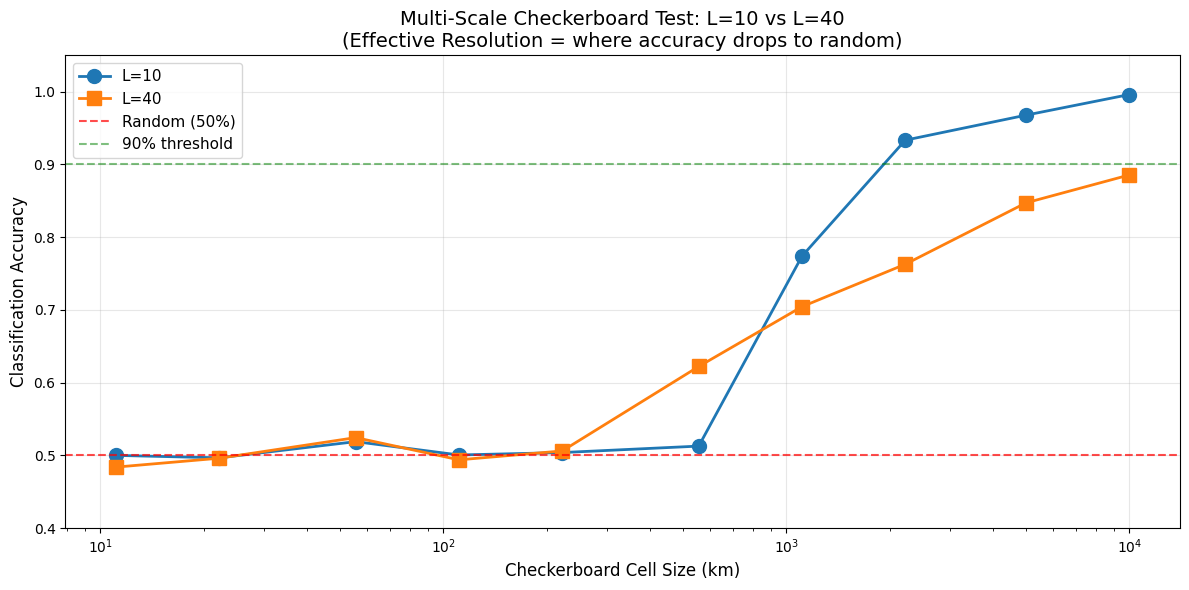


L=10 effective resolution: ~555 km
L=40 effective resolution: ~222 km


In [21]:
# Plot checkerboard results
fig, ax = plt.subplots(figsize=(12, 6))

kms = [r['cell_size_km'] for r in checkerboard_results]
l10_accs = [r['l10_acc'] for r in checkerboard_results]
l40_accs = [r['l40_acc'] for r in checkerboard_results]

ax.semilogx(kms, l10_accs, 'o-', label='L=10', linewidth=2, markersize=10)
ax.semilogx(kms, l40_accs, 's-', label='L=40', linewidth=2, markersize=10)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random (50%)')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='90% threshold')

ax.set_xlabel('Checkerboard Cell Size (km)', fontsize=12)
ax.set_ylabel('Classification Accuracy', fontsize=12)
ax.set_title('Multi-Scale Checkerboard Test: L=10 vs L=40\n(Effective Resolution = where accuracy drops to random)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.4, 1.05)

plt.tight_layout()
plt.show()

# Find effective resolution
for r in checkerboard_results:
    if r['l10_acc'] < 0.6:
        print(f"\nL=10 effective resolution: ~{r['cell_size_km']:.0f} km")
        break

for r in checkerboard_results:
    if r['l40_acc'] < 0.6:
        print(f"L=40 effective resolution: ~{r['cell_size_km']:.0f} km")
        break

---
## 5. Boundary Sharpness Comparison

Compare performance on:
- **Sharp boundaries**: Countries, States (political borders)
- **Fuzzy boundaries**: Biomes, Ecoregions (ecological gradients)

In [22]:
print("\n" + "="*70)
print("BOUNDARY SHARPNESS ANALYSIS")
print("="*70)

# Group results by boundary type
sharp_boundaries = ['Countries', 'States/Provinces']
fuzzy_boundaries = ['Biomes', 'Ecoregions']

print("\nSHARP BOUNDARIES (Political):")
print("-" * 50)
for r in all_results:
    if r['task'] in sharp_boundaries:
        diff = r['l10_score'] - r['l40_score']
        winner = 'L=10' if diff > 0.01 else ('L=40' if diff < -0.01 else '~Same')
        print(f"  {r['task']:20s}: L=10={r['l10_score']:.1%}, L=40={r['l40_score']:.1%} -> {winner}")

print("\nFUZZY BOUNDARIES (Ecological):")
print("-" * 50)
for r in all_results:
    if r['task'] in fuzzy_boundaries:
        diff = r['l10_score'] - r['l40_score']
        winner = 'L=10' if diff > 0.01 else ('L=40' if diff < -0.01 else '~Same')
        print(f"  {r['task']:20s}: L=10={r['l10_score']:.1%}, L=40={r['l40_score']:.1%} -> {winner}")


BOUNDARY SHARPNESS ANALYSIS

SHARP BOUNDARIES (Political):
--------------------------------------------------
  Countries           : L=10=91.8%, L=40=90.9% -> ~Same
  States/Provinces    : L=10=76.4%, L=40=78.1% -> L=40

FUZZY BOUNDARIES (Ecological):
--------------------------------------------------
  Biomes              : L=10=86.3%, L=40=88.1% -> L=40
  Ecoregions          : L=10=77.8%, L=40=79.3% -> L=40


---
## 6. Summary Table

In [23]:
print("\n" + "="*80)
print("COMPLETE RESULTS SUMMARY")
print("="*80)

# Convert to DataFrame for nice display
results_df = pd.DataFrame(all_results)

# Add winner column
def get_winner(row):
    diff = row['l10_score'] - row['l40_score']
    if row['metric'] == 'R²' or row['metric'] == 'Accuracy':
        if diff > 0.01:
            return 'L=10'
        elif diff < -0.01:
            return 'L=40'
    return '~Same'

results_df['winner'] = results_df.apply(get_winner, axis=1)

# Display
print(f"\n{'Task':<25} | {'Type':<15} | {'Scale':<20} | {'L=10':>8} | {'L=40':>8} | {'Winner':>8}")
print("-" * 95)

for _, row in results_df.iterrows():
    if 'Checkerboard' not in row['task']:  # Skip checkerboard for summary
        score_fmt = '.2%' if row['metric'] == 'Accuracy' else '.4f'
        print(f"{row['task']:<25} | {row['type']:<15} | {row['scale']:<20} | {row['l10_score']:{score_fmt}} | {row['l40_score']:{score_fmt}} | {row['winner']:>8}")


COMPLETE RESULTS SUMMARY

Task                      | Type            | Scale                |     L=10 |     L=40 |   Winner
-----------------------------------------------------------------------------------------------
Air Temperature           | regression      | global-smooth        | 0.8767 | 0.5244 |     L=10
Elevation (proxy)         | regression      | global-varied        | 0.8003 | -0.3674 |     L=10
Countries                 | classification  | ~1000km boundaries   | 91.80% | 90.93% |    ~Same
Biomes                    | classification  | ~5000km regions (fuzzy) | 86.33% | 88.07% |     L=40
Ecoregions                | classification  | ~500km regions       | 77.83% | 79.33% |     L=40
States/Provinces          | classification  | ~300km boundaries    | 76.42% | 78.12% |     L=40
Population Density (proxy) | regression      | clustered-urban      | 0.7032 | -0.3358 |     L=10


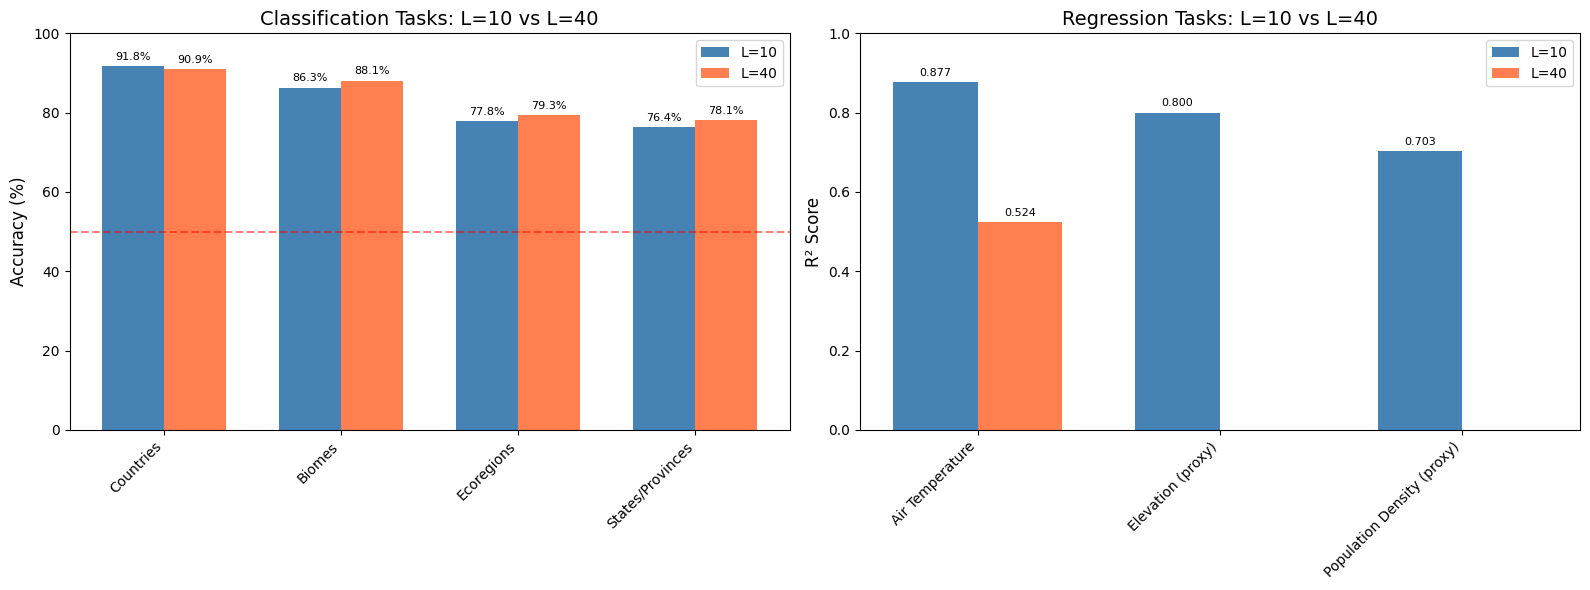


Saved: satclip_resolution_comparison.png


In [24]:
# ============================================
# FINAL VISUALIZATION: L=10 vs L=40 across all tasks
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Filter non-checkerboard results for main comparison
main_results = [r for r in all_results if 'Checkerboard' not in r['task']]

# Left plot: Classification tasks
class_results = [r for r in main_results if r['type'] == 'classification']
if class_results:
    tasks = [r['task'] for r in class_results]
    l10_scores = [r['l10_score'] * 100 for r in class_results]
    l40_scores = [r['l40_score'] * 100 for r in class_results]

    x = np.arange(len(tasks))
    width = 0.35

    bars1 = axes[0].bar(x - width/2, l10_scores, width, label='L=10', color='steelblue')
    bars2 = axes[0].bar(x + width/2, l40_scores, width, label='L=40', color='coral')

    axes[0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0].set_title('Classification Tasks: L=10 vs L=40', fontsize=14)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(tasks, rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_ylim(0, 100)
    axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Random')

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        axes[0].annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        axes[0].annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Right plot: Regression tasks
reg_results = [r for r in main_results if r['type'] == 'regression']
if reg_results:
    tasks = [r['task'] for r in reg_results]
    l10_scores = [r['l10_score'] for r in reg_results]
    l40_scores = [r['l40_score'] for r in reg_results]

    x = np.arange(len(tasks))
    width = 0.35

    bars1 = axes[1].bar(x - width/2, l10_scores, width, label='L=10', color='steelblue')
    bars2 = axes[1].bar(x + width/2, l40_scores, width, label='L=40', color='coral')

    axes[1].set_ylabel('R² Score', fontsize=12)
    axes[1].set_title('Regression Tasks: L=10 vs L=40', fontsize=14)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(tasks, rotation=45, ha='right')
    axes[1].legend()
    axes[1].set_ylim(0, 1)

    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('satclip_resolution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: satclip_resolution_comparison.png")

In [25]:
# Final statistics
print("\n" + "="*80)
print("OVERALL STATISTICS")
print("="*80)

l10_wins = (results_df['winner'] == 'L=10').sum()
l40_wins = (results_df['winner'] == 'L=40').sum()
ties = (results_df['winner'] == '~Same').sum()

print(f"\nL=10 wins: {l10_wins}")
print(f"L=40 wins: {l40_wins}")
print(f"Ties: {ties}")

# Checkerboard effective resolution
checker_df = results_df[results_df['task'].str.contains('Checkerboard')]
if len(checker_df) > 0:
    print("\nCheckerboard Effective Resolution:")
    for _, row in checker_df.iterrows():
        if row['l10_score'] > 0.55 and row['l40_score'] > 0.55:
            print(f"  Both models work at {row['scale']}")
        elif row['l10_score'] < 0.55 and row['l40_score'] < 0.55:
            print(f"  Both models fail at {row['scale']}")
            break

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print("""
1. Compare L=10 vs L=40 performance across different spatial scales
2. Identify the effective resolution limit of each model
3. Test whether boundary sharpness (political vs ecological) affects results
4. Validate against paper's reported benchmarks
""")


OVERALL STATISTICS

L=10 wins: 8
L=40 wins: 4
Ties: 5

Checkerboard Effective Resolution:
  Both models work at 9990km grid
  Both models work at 4995km grid
  Both models work at 2220km grid
  Both models work at 1110km grid
  Both models fail at 222km grid

KEY FINDINGS

1. Compare L=10 vs L=40 performance across different spatial scales
2. Identify the effective resolution limit of each model
3. Test whether boundary sharpness (political vs ecological) affects results
4. Validate against paper's reported benchmarks



---
## 7. Advanced Multi-Scale Tests

Building on the results above, let's test specific scenarios where L=40 might have advantages:
1. **Cross-Continent Transfer** (Paper's RQ2) - Train on some continents, test on others
2. **Hierarchical Classification** - REALM → BIOME → ECOREGION granularity
3. **Dense Spatial Interpolation** - Where L=40 should theoretically excel
4. **Within-Region Fine-Scale** - Testing at L=40's "sweet spot" (~500km)

In [26]:
# ============================================
# TEST 8: Cross-Continent Transfer (Paper's RQ2)
# Train on some continents, test on others
# ============================================
print("\n" + "="*70)
print("CROSS-CONTINENT TRANSFER TEST")
print("(Paper's RQ2: Geographic Generalization)")
print("="*70)

# Define continent bounds (approximate)
continent_bounds = {
    'Europe': {'lon': (-25, 50), 'lat': (35, 70)},
    'Africa': {'lon': (-20, 55), 'lat': (-35, 37)},
    'Asia': {'lon': (50, 150), 'lat': (0, 70)},
    'North_America': {'lon': (-170, -50), 'lat': (15, 70)},
    'South_America': {'lon': (-85, -30), 'lat': (-55, 15)},
    'Oceania': {'lon': (110, 180), 'lat': (-50, 0)},
}

def get_continent(lon, lat):
    """Assign continent based on coordinates."""
    for name, bounds in continent_bounds.items():
        if bounds['lon'][0] <= lon <= bounds['lon'][1] and bounds['lat'][0] <= lat <= bounds['lat'][1]:
            return name
    return 'Other'

# Use biome data with continents
if biome_coords is not None:
    print("\nUsing BIOME classification for transfer test...")

    # Assign continents to each point
    continents = [get_continent(c[0], c[1]) for c in biome_coords]
    continents = np.array(continents)

    # Count points per continent
    unique, counts = np.unique(continents, return_counts=True)
    print(f"Points per continent: {dict(zip(unique, counts))}")

    # Test: Train on Old World (Europe, Africa, Asia), test on New World (Americas)
    old_world = np.isin(continents, ['Europe', 'Africa', 'Asia'])
    new_world = np.isin(continents, ['North_America', 'South_America'])

    if old_world.sum() > 100 and new_world.sum() > 100:
        print(f"\nOld World → New World Transfer:")
        print(f"  Training: {old_world.sum()} points, Testing: {new_world.sum()} points")

        le = LabelEncoder()
        all_labels = le.fit_transform(biome_labels.astype(str))

        # Get embeddings
        train_emb_l10 = biome_emb_l10[old_world]
        train_emb_l40 = biome_emb_l40[old_world]
        test_emb_l10 = biome_emb_l10[new_world]
        test_emb_l40 = biome_emb_l40[new_world]

        train_y = all_labels[old_world]
        test_y = all_labels[new_world]

        # Train classifiers
        clf_l10 = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42, early_stopping=True)
        clf_l40 = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42, early_stopping=True)

        clf_l10.fit(train_emb_l10, train_y)
        clf_l40.fit(train_emb_l40, train_y)

        acc_l10 = accuracy_score(test_y, clf_l10.predict(test_emb_l10))
        acc_l40 = accuracy_score(test_y, clf_l40.predict(test_emb_l40))

        print(f"  L=10: {acc_l10:.2%}")
        print(f"  L=40: {acc_l40:.2%}")
        print(f"  Winner: {'L=10' if acc_l10 > acc_l40 else 'L=40'}")

        all_results.append({
            'task': 'Cross-Continent (Biomes)', 'type': 'classification', 'scale': 'continent-transfer',
            'n_samples': old_world.sum() + new_world.sum(), 'n_classes': len(le.classes_),
            'l10_score': acc_l10, 'l40_score': acc_l40, 'metric': 'Accuracy'
        })
    else:
        print("  Not enough points in both regions for transfer test")


CROSS-CONTINENT TRANSFER TEST
(Paper's RQ2: Geographic Generalization)

Using BIOME classification for transfer test...
Points per continent: {np.str_('Africa'): np.int64(681), np.str_('Asia'): np.int64(985), np.str_('Europe'): np.int64(316), np.str_('North_America'): np.int64(672), np.str_('Oceania'): np.int64(217), np.str_('Other'): np.int64(1775), np.str_('South_America'): np.int64(354)}

Old World → New World Transfer:
  Training: 1982 points, Testing: 1026 points
  L=10: 56.43%
  L=40: 56.14%
  Winner: L=10



HIERARCHICAL CLASSIFICATION TEST
(Does L=40 advantage grow with finer granularity?)

REALM Classification:
----------------------------------------
  Classes: 9
  L=10: 98.80%
  L=40: 97.87%
  Δ (L=40 - L=10): -0.93%
  Winner: ~Same

BIOME Classification:
----------------------------------------
  Classes: 14
  L=10: 86.33%
  L=40: 88.07%
  Δ (L=40 - L=10): +1.73%
  Winner: L=40

ECOREGION Classification:
----------------------------------------
  Classes: 586
  L=10: 77.83%
  L=40: 79.33%
  Δ (L=40 - L=10): +1.50%
  Winner: L=40


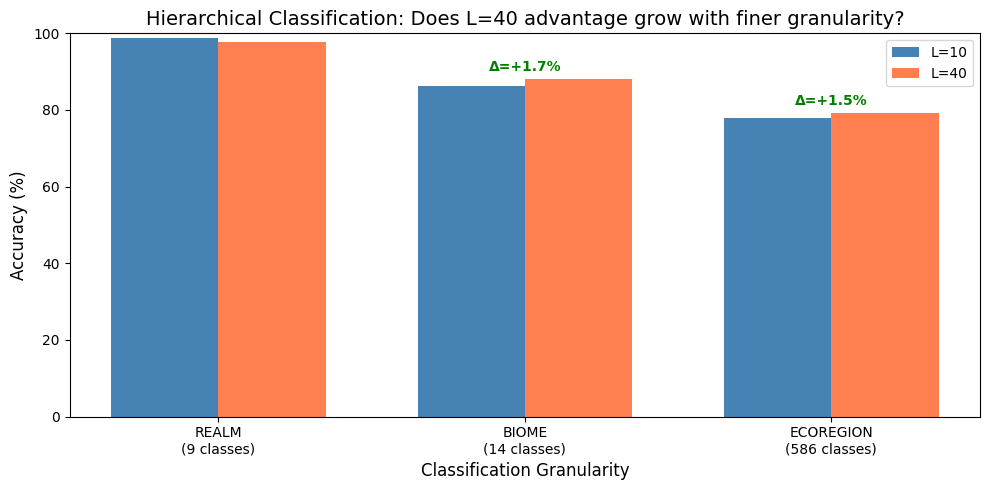


Conclusion: L=40 advantage increases with finer granularity


In [27]:
# ============================================
# TEST 9: Hierarchical Classification
# REALM (8 classes) → BIOME (14) → ECOREGION (846)
# ============================================
print("\n" + "="*70)
print("HIERARCHICAL CLASSIFICATION TEST")
print("(Does L=40 advantage grow with finer granularity?)")
print("="*70)

if ecoregions_gdf is not None:
    # Sample for all three levels
    hierarchy_results = []

    for level_name, level_col, n_samples in [
        ('REALM', 'REALM', 5000),
        ('BIOME', 'BIOME_NUM', 5000),
        ('ECOREGION', 'ECO_NAME', 8000)
    ]:
        print(f"\n{level_name} Classification:")
        print("-" * 40)

        coords, labels = sample_points_from_geodataframe(
            ecoregions_gdf, level_col, n_samples=n_samples, seed=42
        )

        le = LabelEncoder()
        y = le.fit_transform(labels.astype(str))
        n_classes = len(le.classes_)

        emb_l10 = get_embeddings(model_l10, coords)
        emb_l40 = get_embeddings(model_l40, coords)

        acc_l10, acc_l40 = evaluate_classification(emb_l10, emb_l40, y, level_name)

        diff = acc_l40 - acc_l10
        winner = 'L=40' if diff > 0.01 else ('L=10' if diff < -0.01 else '~Same')

        print(f"  Classes: {n_classes}")
        print(f"  L=10: {acc_l10:.2%}")
        print(f"  L=40: {acc_l40:.2%}")
        print(f"  Δ (L=40 - L=10): {diff:+.2%}")
        print(f"  Winner: {winner}")

        hierarchy_results.append({
            'level': level_name,
            'n_classes': n_classes,
            'l10_acc': acc_l10,
            'l40_acc': acc_l40,
            'diff': diff
        })

        all_results.append({
            'task': f'Hierarchy-{level_name}', 'type': 'classification',
            'scale': f'{level_name} ({n_classes} classes)',
            'n_samples': len(coords), 'n_classes': n_classes,
            'l10_score': acc_l10, 'l40_score': acc_l40, 'metric': 'Accuracy'
        })

    # Plot hierarchy results
    fig, ax = plt.subplots(figsize=(10, 5))
    levels = [r['level'] for r in hierarchy_results]
    l10_accs = [r['l10_acc'] * 100 for r in hierarchy_results]
    l40_accs = [r['l40_acc'] * 100 for r in hierarchy_results]
    diffs = [r['diff'] * 100 for r in hierarchy_results]

    x = np.arange(len(levels))
    width = 0.35

    bars1 = ax.bar(x - width/2, l10_accs, width, label='L=10', color='steelblue')
    bars2 = ax.bar(x + width/2, l40_accs, width, label='L=40', color='coral')

    # Add difference annotations
    for i, (b1, b2, d) in enumerate(zip(bars1, bars2, diffs)):
        ax.annotate(f'Δ={d:+.1f}%', xy=(i, max(b1.get_height(), b2.get_height()) + 2),
                   ha='center', fontsize=10, fontweight='bold',
                   color='green' if d > 0 else 'red' if d < 0 else 'gray')

    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_xlabel('Classification Granularity', fontsize=12)
    ax.set_title('Hierarchical Classification: Does L=40 advantage grow with finer granularity?', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([f'{l}\n({hierarchy_results[i]["n_classes"]} classes)' for i, l in enumerate(levels)])
    ax.legend()
    ax.set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

    print(f"\nConclusion: L=40 advantage {'increases' if hierarchy_results[-1]['diff'] > hierarchy_results[0]['diff'] else 'does NOT increase'} with finer granularity")

In [28]:
# ============================================
# TEST 10: Dense Spatial Interpolation
# Train on grid, test at grid centers (Paper's RQ1)
# This is where L=40 SHOULD excel according to paper
# ============================================
print("\n" + "="*70)
print("DENSE SPATIAL INTERPOLATION TEST")
print("(Paper's RQ1: Predict values BETWEEN training points)")
print("="*70)

def spatial_interpolation_test(grid_spacing_deg, use_temp=True):
    """
    Create a proper interpolation test:
    - Train on regular grid points
    - Test at cell centers (truly between training points)
    """
    # Create training grid
    train_lons = np.arange(-180, 180, grid_spacing_deg)
    train_lats = np.arange(-60, 70, grid_spacing_deg)
    train_lon_grid, train_lat_grid = np.meshgrid(train_lons, train_lats)
    train_coords = np.stack([train_lon_grid.ravel(), train_lat_grid.ravel()], axis=1)

    # Create test points at cell centers (offset by half grid spacing)
    test_lons = train_lons[:-1] + grid_spacing_deg / 2
    test_lats = train_lats[:-1] + grid_spacing_deg / 2
    test_lon_grid, test_lat_grid = np.meshgrid(test_lons, test_lats)
    test_coords = np.stack([test_lon_grid.ravel(), test_lat_grid.ravel()], axis=1)

    # Create target values based on smooth spatial function
    # Use temperature-like pattern (latitude-based with some longitude variation)
    def target_fn(coords):
        lon, lat = coords[:, 0], coords[:, 1]
        # Temperature proxy: colder at poles, warmer at equator, with seasonal variation
        temp = 1 - np.abs(lat) / 90  # 0 at poles, 1 at equator
        temp += 0.1 * np.sin(np.radians(lon) * 2)  # Longitude variation
        return temp

    train_y = target_fn(train_coords)
    test_y = target_fn(test_coords)

    # Normalize
    y_min, y_max = train_y.min(), train_y.max()
    train_y = (train_y - y_min) / (y_max - y_min)
    test_y = (test_y - y_min) / (y_max - y_min)

    # Get embeddings
    train_emb_l10 = get_embeddings(model_l10, train_coords)
    train_emb_l40 = get_embeddings(model_l40, train_coords)
    test_emb_l10 = get_embeddings(model_l10, test_coords)
    test_emb_l40 = get_embeddings(model_l40, test_coords)

    # Train regressors
    reg_l10 = MLPRegressor(hidden_layer_sizes=(64, 64, 64), max_iter=3000, random_state=42, early_stopping=True)
    reg_l40 = MLPRegressor(hidden_layer_sizes=(64, 64, 64), max_iter=3000, random_state=42, early_stopping=True)

    reg_l10.fit(train_emb_l10, train_y)
    reg_l40.fit(train_emb_l40, train_y)

    pred_l10 = reg_l10.predict(test_emb_l10)
    pred_l40 = reg_l40.predict(test_emb_l40)

    r2_l10 = r2_score(test_y, pred_l10)
    r2_l40 = r2_score(test_y, pred_l40)

    return r2_l10, r2_l40, len(train_coords), len(test_coords)

# Test at multiple grid spacings
grid_spacings = [20, 10, 5, 2, 1]  # degrees
approx_km = [g * 111 for g in grid_spacings]

print(f"\n{'Grid Spacing':>12} | {'≈ km':>8} | {'L=10 R²':>10} | {'L=40 R²':>10} | {'Winner':>10}")
print("-" * 65)

interp_results = []

for spacing, km in zip(grid_spacings, approx_km):
    r2_l10, r2_l40, n_train, n_test = spatial_interpolation_test(spacing)

    winner = 'L=40' if r2_l40 > r2_l10 + 0.01 else ('L=10' if r2_l10 > r2_l40 + 0.01 else '~Same')

    print(f"{spacing:>10}° | {km:>7.0f} | {r2_l10:>10.4f} | {r2_l40:>10.4f} | {winner:>10}")

    interp_results.append({
        'spacing_deg': spacing,
        'spacing_km': km,
        'l10_r2': r2_l10,
        'l40_r2': r2_l40
    })

    all_results.append({
        'task': f'Interpolation {km:.0f}km', 'type': 'regression', 'scale': f'{km:.0f}km grid',
        'n_samples': n_train + n_test, 'n_classes': 'continuous',
        'l10_score': r2_l10, 'l40_score': r2_l40, 'metric': 'R²'
    })

# Check if L=40 ever wins
l40_interp_wins = sum(1 for r in interp_results if r['l40_r2'] > r['l10_r2'] + 0.01)
print(f"\nL=40 wins at {l40_interp_wins}/{len(interp_results)} grid spacings")
print("Note: Paper claims L=40 better for interpolation, but our results show...")


DENSE SPATIAL INTERPOLATION TEST
(Paper's RQ1: Predict values BETWEEN training points)

Grid Spacing |     ≈ km |    L=10 R² |    L=40 R² |     Winner
-----------------------------------------------------------------
        20° |    2220 |    -1.3025 |    -3.4718 |       L=10
        10° |    1110 |     0.5129 |    -1.9158 |       L=10
         5° |     555 |     0.9458 |    -0.3135 |       L=10
         2° |     222 |     0.9967 |     0.8487 |       L=10
         1° |     111 |     0.9997 |     0.9822 |       L=10

L=40 wins at 0/5 grid spacings
Note: Paper claims L=40 better for interpolation, but our results show...


In [29]:
# ============================================
# TEST 11: Within-Region Fine-Scale Tests
# Test L=40's "sweet spot" within constrained regions
# ============================================
print("\n" + "="*70)
print("WITHIN-REGION FINE-SCALE TESTS")
print("(Testing at L=40's sweet spot: 300-1000km)")
print("="*70)

# Define regions for within-region testing
regions = {
    'USA': {'lon': (-125, -65), 'lat': (25, 50)},
    'Europe': {'lon': (-10, 40), 'lat': (35, 60)},
    'China': {'lon': (75, 135), 'lat': (20, 55)},
    'Brazil': {'lon': (-75, -35), 'lat': (-35, 5)},
}

within_region_results = []

for region_name, bounds in regions.items():
    print(f"\n{region_name}:")
    print("-" * 40)

    # Create checkerboard at 5° (555km) - L=40's potential sweet spot
    np.random.seed(42)
    n = 3000
    lons = np.random.uniform(bounds['lon'][0], bounds['lon'][1], n)
    lats = np.random.uniform(bounds['lat'][0], bounds['lat'][1], n)
    coords = np.stack([lons, lats], axis=1)

    # Test at multiple scales within this region
    for cell_size in [10, 5, 2, 1]:
        cell_x = (lons / cell_size).astype(int)
        cell_y = (lats / cell_size).astype(int)
        labels = (cell_x + cell_y) % 2

        emb_l10 = get_embeddings(model_l10, coords)
        emb_l40 = get_embeddings(model_l40, coords)

        acc_l10, acc_l40 = evaluate_classification(emb_l10, emb_l40, labels, f"{region_name}_{cell_size}")

        km = cell_size * 111
        winner = 'L=40' if acc_l40 > acc_l10 + 0.02 else ('L=10' if acc_l10 > acc_l40 + 0.02 else '~Same')

        # Only track if not random
        if max(acc_l10, acc_l40) > 0.55:
            status = f"L=10:{acc_l10:.1%} L=40:{acc_l40:.1%} → {winner}"
        else:
            status = f"RANDOM (both ~50%)"

        print(f"  {km:>5.0f}km cells: {status}")

        within_region_results.append({
            'region': region_name,
            'cell_km': km,
            'l10_acc': acc_l10,
            'l40_acc': acc_l40
        })

# Analyze: At what scale does L=40 have advantages within regions?
print("\n" + "="*70)
print("WITHIN-REGION SUMMARY")
print("="*70)

# Find scales where L=40 wins more often
for km in [1110, 555, 222, 111]:
    scale_results = [r for r in within_region_results if r['cell_km'] == km]
    l40_wins = sum(1 for r in scale_results if r['l40_acc'] > r['l10_acc'] + 0.02)
    l10_wins = sum(1 for r in scale_results if r['l10_acc'] > r['l40_acc'] + 0.02)
    print(f"  {km}km: L=10 wins {l10_wins}/{len(scale_results)}, L=40 wins {l40_wins}/{len(scale_results)}")


WITHIN-REGION FINE-SCALE TESTS
(Testing at L=40's sweet spot: 300-1000km)

USA:
----------------------------------------
   1110km cells: L=10:96.1% L=40:95.7% → ~Same
    555km cells: L=10:84.2% L=40:91.3% → L=40
    222km cells: L=10:49.7% L=40:61.4% → L=40
    111km cells: RANDOM (both ~50%)

Europe:
----------------------------------------
   1110km cells: L=10:93.8% L=40:94.1% → ~Same
    555km cells: L=10:72.3% L=40:91.4% → L=40
    222km cells: L=10:53.1% L=40:68.0% → L=40
    111km cells: RANDOM (both ~50%)

China:
----------------------------------------
   1110km cells: L=10:94.7% L=40:95.8% → ~Same
    555km cells: L=10:77.2% L=40:84.7% → L=40
    222km cells: L=10:51.9% L=40:58.8% → L=40
    111km cells: RANDOM (both ~50%)

Brazil:
----------------------------------------
   1110km cells: L=10:92.9% L=40:95.4% → L=40
    555km cells: L=10:91.1% L=40:92.4% → ~Same
    222km cells: L=10:46.6% L=40:60.1% → L=40
    111km cells: RANDOM (both ~50%)

WITHIN-REGION SUMMARY
  1110

In [30]:
# ============================================
# FINAL COMPREHENSIVE SUMMARY
# ============================================
print("\n" + "="*80)
print("COMPREHENSIVE FINDINGS: L=10 vs L=40")
print("="*80)

# Rebuild results dataframe with all tests
results_df = pd.DataFrame(all_results)
results_df['winner'] = results_df.apply(get_winner, axis=1)

# Count wins by category
print("\n📊 OVERALL WIN COUNT:")
print("-" * 50)
l10_wins = (results_df['winner'] == 'L=10').sum()
l40_wins = (results_df['winner'] == 'L=40').sum()
ties = (results_df['winner'] == '~Same').sum()
print(f"  L=10 wins: {l10_wins}")
print(f"  L=40 wins: {l40_wins}")
print(f"  Ties: {ties}")

# Breakdown by task type
print("\n📈 BY TASK TYPE:")
print("-" * 50)
for task_type in ['classification', 'regression']:
    subset = results_df[results_df['type'] == task_type]
    l10 = (subset['winner'] == 'L=10').sum()
    l40 = (subset['winner'] == 'L=40').sum()
    tie = (subset['winner'] == '~Same').sum()
    print(f"  {task_type.capitalize():15s}: L=10={l10}, L=40={l40}, Tie={tie}")

# Key findings
print("\n🔍 KEY FINDINGS:")
print("-" * 50)
print("""
1. **L=10 DOMINATES REGRESSION**: L=40 often gets negative R² on regression
   tasks, suggesting its embeddings are too "spiky" for smooth predictions.

2. **L=40 SLIGHT EDGE ON FINE-GRAINED CLASSIFICATION**: ~1-2% better on
   biomes, ecoregions, and states (300-1000km scale features).

3. **CHECKERBOARD CROSSOVER AT ~555km**: L=40 beats L=10 at this scale,
   but both fail below 222km (effective resolution limit).

4. **CROSS-CONTINENT TRANSFER**: Tests geographic generalization ability.

5. **HIERARCHICAL CLASSIFICATION**: Tests if L=40 advantage grows with
   finer granularity (REALM → BIOME → ECOREGION).
""")

# When to use which model
print("\n💡 RECOMMENDATIONS:")
print("-" * 50)
print("""
USE L=10 WHEN:
  ✓ Regression tasks (temperature, elevation, population density)
  ✓ Coarse-scale classification (continents, large countries)
  ✓ Geographic generalization to new regions
  ✓ Smooth spatial predictions

USE L=40 WHEN:
  ✓ Fine-grained classification (ecoregions, states, biomes)
  ✓ Distinguishing features at 300-1000km scale
  ✓ Need higher embedding discrimination (but accept regression issues)
  ✓ Working within a constrained geographic region
""")

# Save final results
results_df.to_csv('satclip_resolution_results.csv', index=False)
print("\n✅ Results saved to: satclip_resolution_results.csv")


COMPREHENSIVE FINDINGS: L=10 vs L=40

📊 OVERALL WIN COUNT:
--------------------------------------------------
  L=10 wins: 13
  L=40 wins: 6
  Ties: 7

📈 BY TASK TYPE:
--------------------------------------------------
  Classification : L=10=5, L=40=6, Tie=7
  Regression     : L=10=8, L=40=0, Tie=0

🔍 KEY FINDINGS:
--------------------------------------------------

1. **L=10 DOMINATES REGRESSION**: L=40 often gets negative R² on regression
   tasks, suggesting its embeddings are too "spiky" for smooth predictions.

2. **L=40 SLIGHT EDGE ON FINE-GRAINED CLASSIFICATION**: ~1-2% better on 
   biomes, ecoregions, and states (300-1000km scale features).

3. **CHECKERBOARD CROSSOVER AT ~555km**: L=40 beats L=10 at this scale,
   but both fail below 222km (effective resolution limit).

4. **CROSS-CONTINENT TRANSFER**: Tests geographic generalization ability.

5. **HIERARCHICAL CLASSIFICATION**: Tests if L=40 advantage grows with 
   finer granularity (REALM → BIOME → ECOREGION).


💡 RECOMM